In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *

In [5]:
# assortment of relevant BED files with the features of interest ...
rloops_ONLY = "intersect-Rloops-NO-all-NT-CTCF-NO-G4-Mao"
ctcf_peaks_w_G4 = "intersect-all-NT-CTCF-NO-Rloops-G4-Mao"
ctcf_peaks_ONLY = "intersect-all-NT-CTCF-NO-Rloops-NO-G4-Mao"

# K562 -different cell line
allRloops = "GSM1720619_K562_DRIP_peaks-sort.bed"
allG4 = "G4-Mao-sort"

# differential splicing events: noCTCF - CTCF(without TIR1)
splice_deltaCTCF = "S44_NT_S442_IAA.output_events_all_select_hg19.txt"
# now it's a DDX5 mutant ...AAVS is a control for DDX55 clone
splice_deltaDDX55 = "AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt"

# bounds = "merged_bounds.bed"
# bounds = "rad21_merged.bed"
bounds = "union_RAD21_CTCF.bed"
# bounds = "NT-RAD21-narrowPeaks-sort-merge"
# bounds = "IAA-RAD21-narrowPeaks-sort-merge"
# bounds = "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed"

feature_of_interest = bounds

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [6]:
# it's nice sometimes to exclude sex chromosomes and mito for analysis
autosomal_chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',
 'chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17',
 'chr18','chr19','chr20','chr21','chr22']

In [7]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"],
    usecols=(0,1,2),
    index_col=None
)
df = df.sort_values(["chrom","start"])
df = df[~(df["chrom"] == "chrM")]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


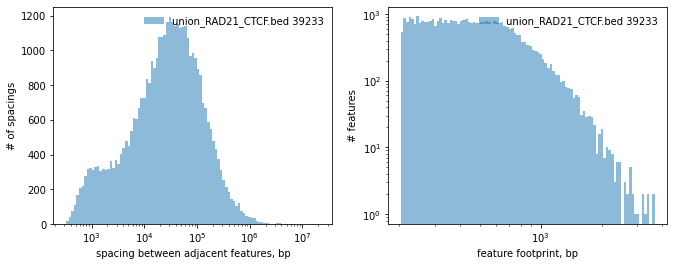

In [8]:
plot_spacing_footprint_distros({
    feature_of_interest : df
})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 39233 -> 38226


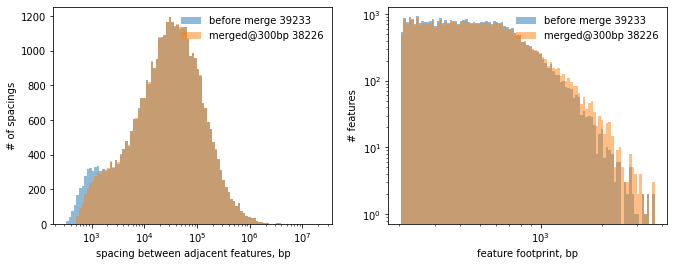

In [9]:
merge_radius = 300
df_merged = bf.merge(df, min_dist=merge_radius)
print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

plot_spacing_footprint_distros({
    "before merge" : df,
    f"merged@{merge_radius}bp" : df_merged,
})

### let's have the original CTCF and RAD21 peak calls here to count them along our stackups as well (kind of sliding window, but not really sliding ...) ...

Also we agreed to add matching motif analyses here - G4-seq(not quite a motif, but just another way to get at G4-s) and FIMO-scanned CTCF `MA0139.1` motifs as well ...

In [42]:
# bioframe is short for bioframe here ...
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)
# ctcf_df = bf.merge(ctcf_df, min_dist=merge_radius)

In [43]:
rad21_df = bioframe.read_table(
    "NT-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_df = rad21_df.sort_values(["chrom","start"])
rad21_df = rad21_df[ rad21_df["chrom"].isin(autosomal_chroms) ]
rad21_df = rad21_df.reset_index(drop=True)
# rad21_df = bf.merge(rad21_df, min_dist=merge_radius)

In [44]:
rad21_IAA_df = bioframe.read_table(
    "IAA-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_IAA_df = rad21_IAA_df.sort_values(["chrom","start"])
rad21_IAA_df = rad21_IAA_df[ rad21_IAA_df["chrom"].isin(autosomal_chroms) ]
rad21_IAA_df = rad21_IAA_df.reset_index(drop=True)
# rad21_IAA_df = bf.merge(rad21_IAA_df, min_dist=merge_radius)

In [53]:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt

# according to FIMO docs - we shouldn't be doing a motif scan genome-wide because of multiple hypothesis testing issue
# and the shear amount of false positives that it would bring - but we'll do it anyways - and we try our best with the
# stringewnt cutoff ...

# require tr -s '\t' - to remove duplicated tabs
ctcf_motif = bioframe.read_table(
    "CTCF.MA0139.1.txt",
    names=["name","chrom","start","end","strand","score","pval","seq"],
    sep="\t",
    index_col = None
)
ctcf_motif = ctcf_motif.sort_values(["chrom","start"])
ctcf_motif = ctcf_motif[ ctcf_motif["chrom"].isin(autosomal_chroms) ]
ctcf_motif = ctcf_motif.reset_index(drop=True)
pval_threshold = 5e-6 # 5e-6 - looks reasonable - we liked 5e-6 a lot
ctcf_motif_filtered = ctcf_motif[ctcf_motif["pval"]<pval_threshold].reset_index(drop=True)
ctcf_motif = bf.merge(
    ctcf_motif_filtered,
#     min_dist=merge_radius # no pre-merging ...
)
ctcf_motif.head()
print(f"CTCF-motifs after filtering/mergign etc {len(ctcf_motif)} ...")


CTCF-motifs after filtering/mergign etc 102141 ...


In [46]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")
G4_polstall.head()

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


chrom  start    end  n_intervals
0  chr1   9999  10524            1
1  chr1  15058  15238            1
2  chr1  16680  16770            1
3  chr1  16785  16858            1
4  chr1  21143  21593            1

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [16]:
# describe samples ....

samples = {}

# each sample would have several attributres related to stackups ... - fname, binsize, flank, datarange, colormap
samples["ctcf"] = {"fname": "NT-CTCF_R1.mLb.clN.bigWig", # "log2CTCF_input_SES.bw
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,1.5),
                   "cmap":cmap3,
                  }
samples["noctcf"] = {"fname":"IAA-CTCF_R1.mLb.clN.bigWig",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,1.5),
                   "cmap":cmap3,
                  }
samples["rad21_CTCF"] = {"fname":"NT-RAD21_R1.mLb.clN.bigWig",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,.4),
                   "cmap":cmap3,
                  }
samples["rad21_noCTCF"] = {"fname":"IAA-RAD21_R1.mLb.clN.bigWig",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,.4),
                   "cmap":cmap3,
                  }
# best G4 track that we found ...
samples["G4a_r2"] = {"fname":"GSM2876095_B_REP2.SLX-12320.K562_P9_Async_a_701_517.rmdup.clean.bw",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,30),
                   "cmap":cmap3,
                  }
# add ddx for fun ...
samples["ddx_CTCF"] = {"fname":"NT-DDX55_R1.mLb.clN.bigWig",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,.4),
                   "cmap":cmap3,
                  }
samples["ddx_noCTCF"] = {"fname":"IAA-DDX55_R1.mLb.clN.bigWig",
                   "binsize":200,
                   "flank":5_000,
                   "crange":(0,.4),
                   "cmap":cmap3,
                  }



ins_binsize = 2_000
ins_diamond = 20_000
ins_binsize_human = f"{int(ins_binsize/1000)}kb"
ins_diamond_human = f"{int(ins_diamond/1000)}kb"
# deeper versions - combined for nice insulation stackups (todo - make sure CTCF and noCTCF - are at comparable depth)...
samples["ins_CTCF"] = {"fname":f"CkoCT442_NT_pool.hg19.{ins_binsize_human}.{ins_diamond_human}.bw",
                   "binsize":ins_binsize,
                   "flank":2*ins_diamond,
                   "crange":(-.5,.5),
                   "cmap":cmap2,
                  }
samples["ins_noCTCF"] = {"fname":f"CkoCT442_IAA_pool.hg19.{ins_binsize_human}.{ins_diamond_human}.bw",
                   "binsize":ins_binsize,
                   "flank":2*ins_diamond,
                   "crange":(-.5,.5),
                   "cmap":cmap2,
                  }


In [17]:
#let's describe our samples that we want to have in Figure 1 ...
fig1_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2"]#,"ddx_CTCF","ddx_noCTCF"]

titles = fig1_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig1_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [18]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s] )

stacking up ctcf ...
CPU times: user 11.6 s, sys: 908 ms, total: 12.5 s
Wall time: 12.5 s
stacking up noctcf ...
CPU times: user 10.6 s, sys: 877 ms, total: 11.5 s
Wall time: 11.5 s
stacking up rad21_CTCF ...
CPU times: user 12.4 s, sys: 911 ms, total: 13.3 s
Wall time: 13.2 s
stacking up rad21_noCTCF ...
CPU times: user 9.72 s, sys: 655 ms, total: 10.4 s
Wall time: 10.4 s
stacking up ins_CTCF ...
CPU times: user 8.52 s, sys: 649 ms, total: 9.17 s
Wall time: 9.15 s
stacking up ins_noCTCF ...
CPU times: user 8.35 s, sys: 739 ms, total: 9.09 s
Wall time: 9.05 s
stacking up G4a_r2 ...
CPU times: user 14.7 s, sys: 784 ms, total: 15.5 s
Wall time: 15.5 s


In [19]:
# we might want to do some flipping later on  - so keeping this here for records
s0 = stackups[fig1_samples[0]]
preflip_index = np.arange(len(s0))
print(s0.shape)

(38226, 50)


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [20]:
# Happens in place ! be carefull !
normalize_insulation_stackups_INPLACE(
    stackups_set = stackups,
    ins_keys = [k for k in stackups.keys() if k.startswith("ins")],
    subtract='mean_top',
    subtract_size=7,
)

### starting with some sorting, keeping legacy sorting approaches for now

In [21]:
# def get_peak_strength(_):
#     chrom,start,end = _
#     return bbi.fetch(
#             bw_fnames["ctcf"], # just an NT CTCF Chip-Seq signal
#             chrom,
#             start,
#             end,
#             bins=1, # extract whole footprint of the peak into 1 value ...
#             missing=0.0,
#             oob=np.nan,
#             summary='mean',
#         )[0]
# ctcf_peak_strength = df_merged[["chrom","start","end"]].apply(get_peak_strength,axis=1)
# bw_fnames["ctcf"]

In [22]:
length,width = stackups['ctcf'].shape
center_bin = int(width/2)
stackups['ctcf_mean'] = np.nanmean(stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
# stackups['rad21_mean'] = np.nanmean(stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
# stackups['sort_metric'] = np.log(stackups['ctcf_mean']) + 0.33*stackups['rad21_mean']

ins_samples = [s for s in fig1_samples if s.startswith("ins")]
# insulation
cmap_ins = copy(matplotlib.cm.get_cmap("YlGnBu_r"))
cmap_ins.set_bad(color='lightgrey')
for s in ins_samples:
    limss[s] = (-.352,-.153)
    cmps[s] = cmap_ins

    
    
initial_index = np.arange( len(stackups['ctcf_mean']) )
ks = [('ctcf_mean', "sort", 1, False)]
# ks = [('RAD21_mean',"sort",5),('RAD21_IAA_mean',"sort",1),  ]
_, jjj = recursive_data_ordering( ks, initial_index, stackups, verbose=True)


sorting 38226 elements of ctcf_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [47]:
from more_itertools import chunked
CHUNK_SIZE = 100

index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
ctcf_peaks_sorted = []
_df2 = ctcf_df
for ii in index_chunks:
    _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    ctcf_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())


In [48]:
index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
rad21_peaks_sorted = []
_df2 = rad21_df
for ii in index_chunks:
    _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    rad21_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
# do we need rad21IAA_peaks_sorted here ?

In [54]:
# CTCF motif preparing for the "grey"-plot
index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
ctcf_motif_sorted = []
_df2 = ctcf_motif # already filtered and pre-merged ...
for ii in index_chunks:
    _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    ctcf_motif_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())

In [50]:
# G4_polstall
index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
G4_polstall_sorted = []
_df2 = G4_polstall # works as is !!!
for ii in index_chunks:
    _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
    G4_polstall_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())

#### plotting those running averages is integrated into `plot_stackups` function ...

In [51]:
index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
Number_of_chunks = len(list(index_chunks))
print(Number_of_chunks)

383


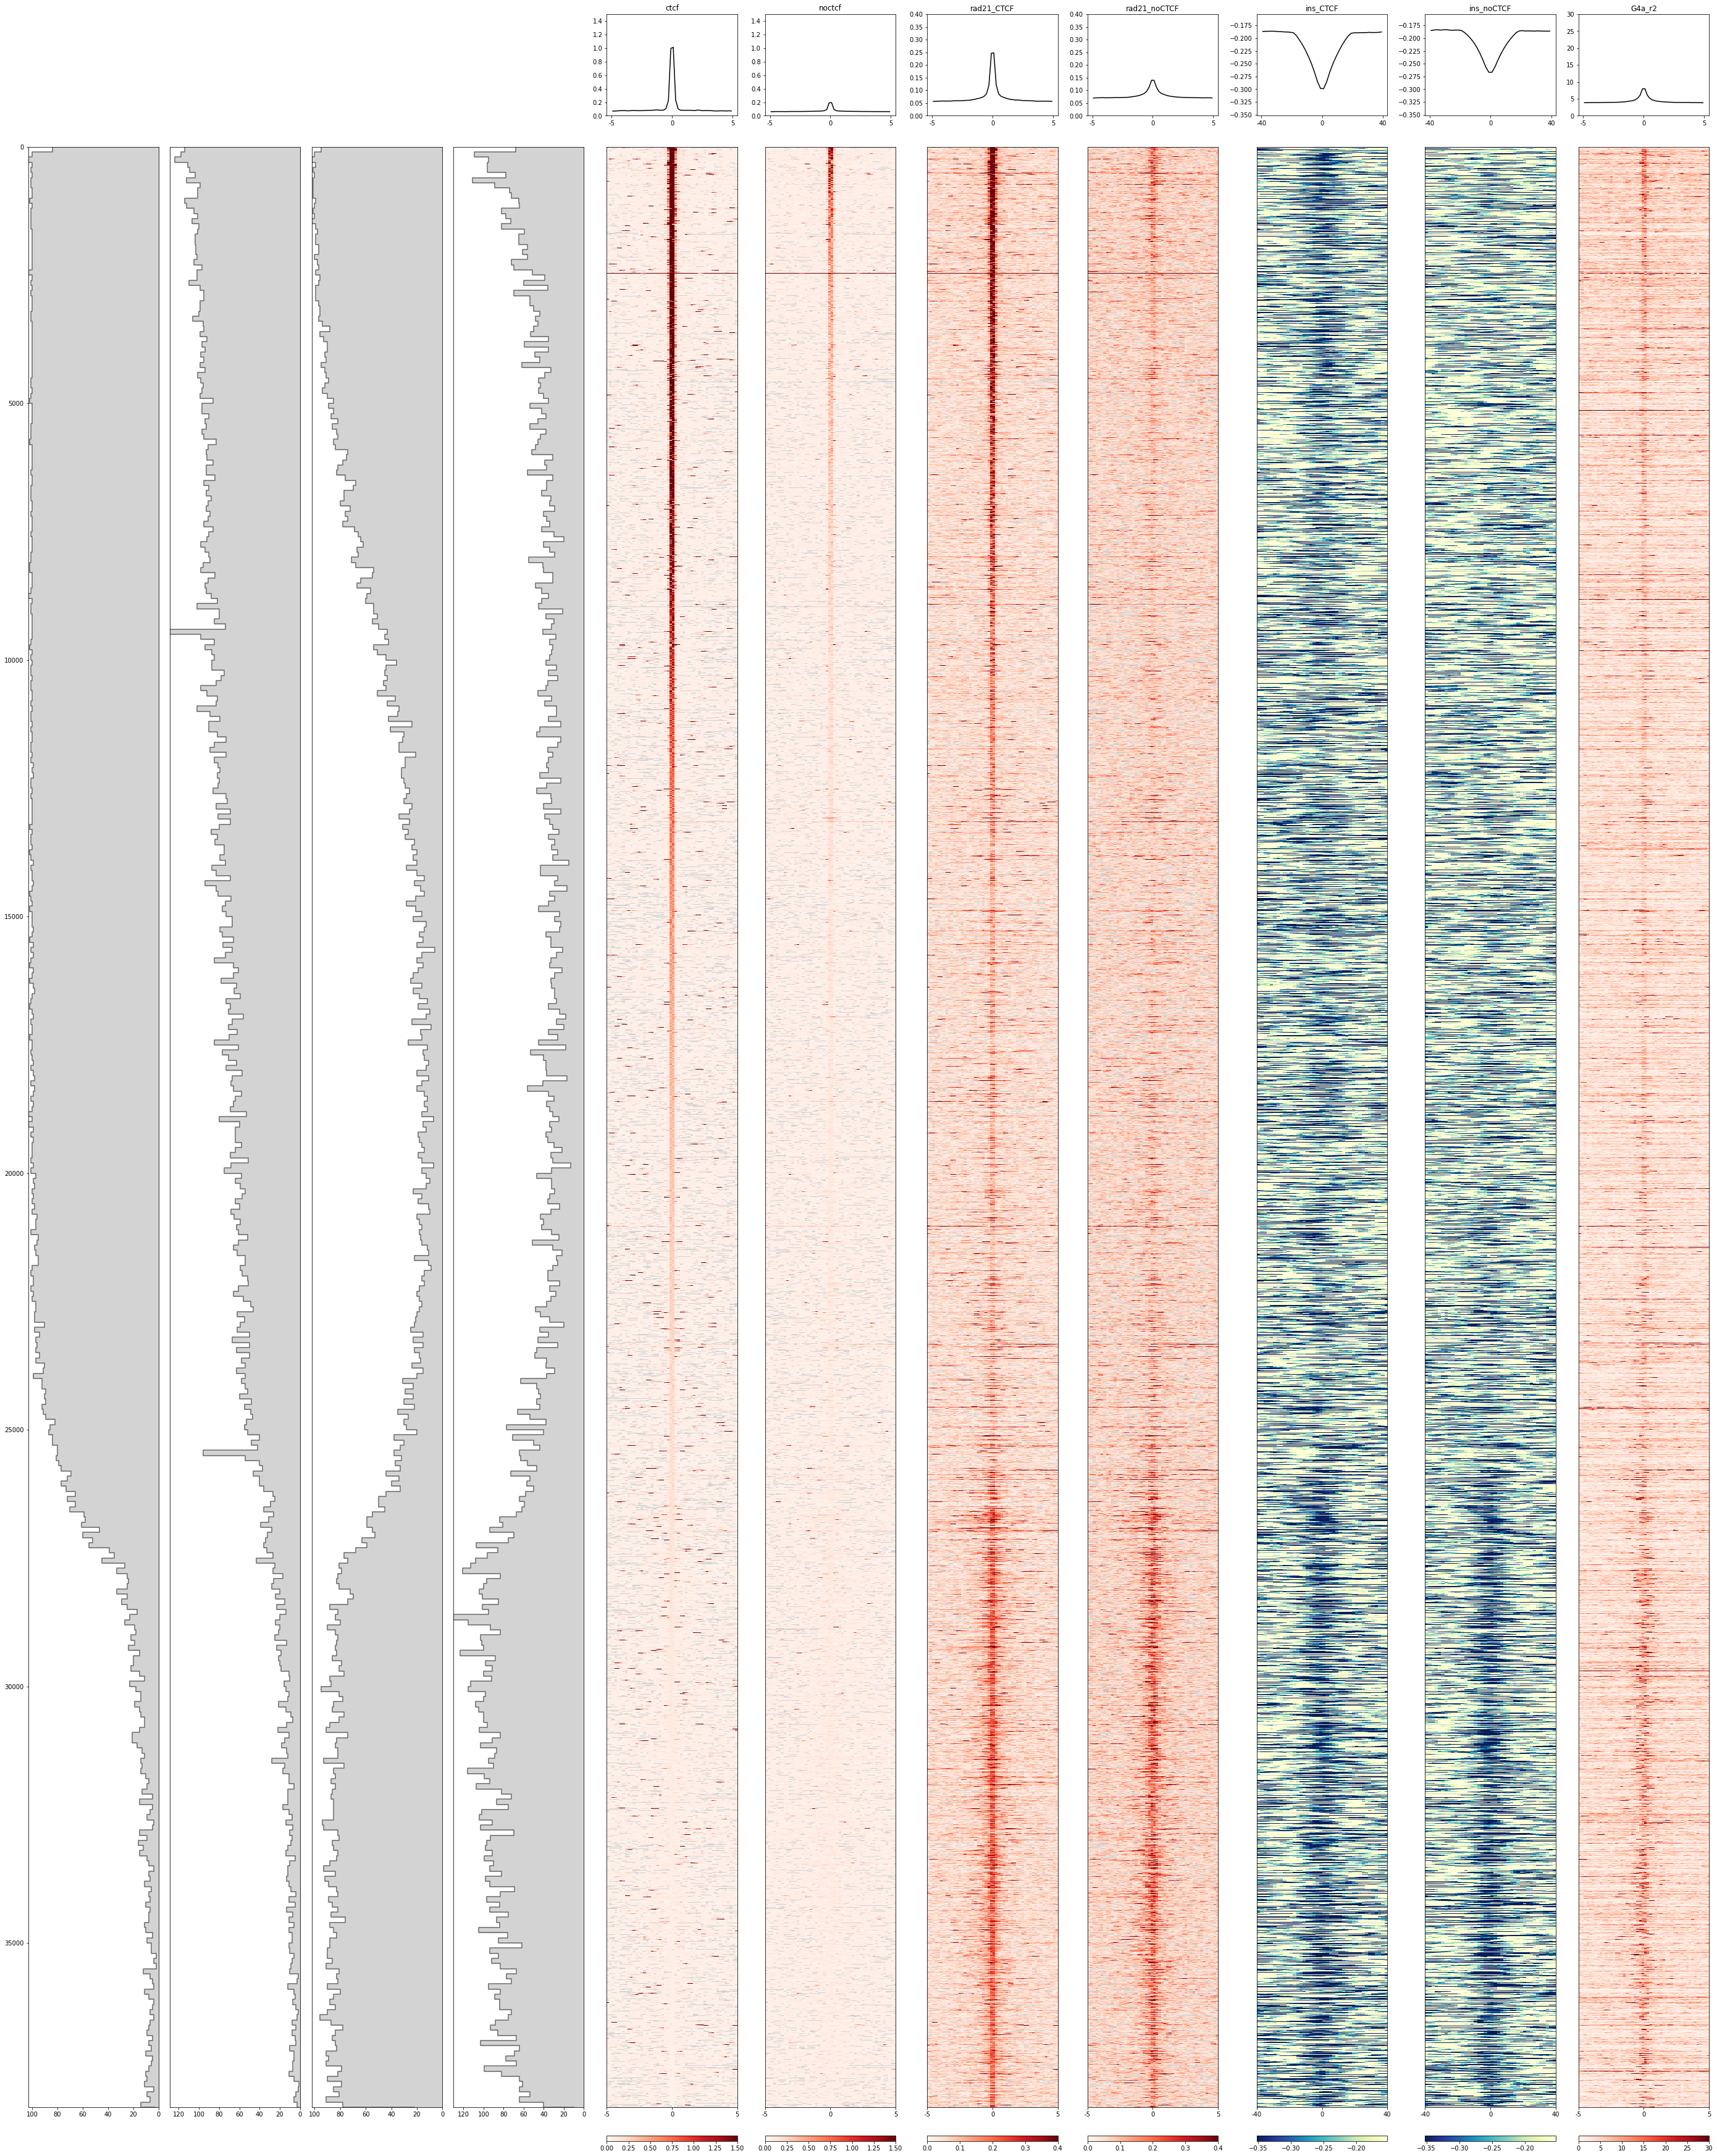

In [55]:
hmss = [ stackups[_k][jjj] for _k in fig1_samples ]
_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

xtra_plots = [
    (np.arange(Number_of_chunks), ctcf_peaks_sorted, "lightgrey"),
    (np.arange(Number_of_chunks), ctcf_motif_sorted, "lightgrey"),
    (np.arange(Number_of_chunks), rad21_peaks_sorted, "lightgrey"),
    (np.arange(Number_of_chunks), G4_polstall_sorted, "lightgrey"),
]

plot_stackups(xtra_plots, hmss,titles, _limss, _cmps, _norms, _binsizes, fname="Fig1_masterlist_all.pdf", fillmissing=False, interpolation="nearest")

### let's plot zoom-ins into CTCF dependent and CTCF independent subsets ...

sorting 10000 elements of G4_mean into 1 groups ...


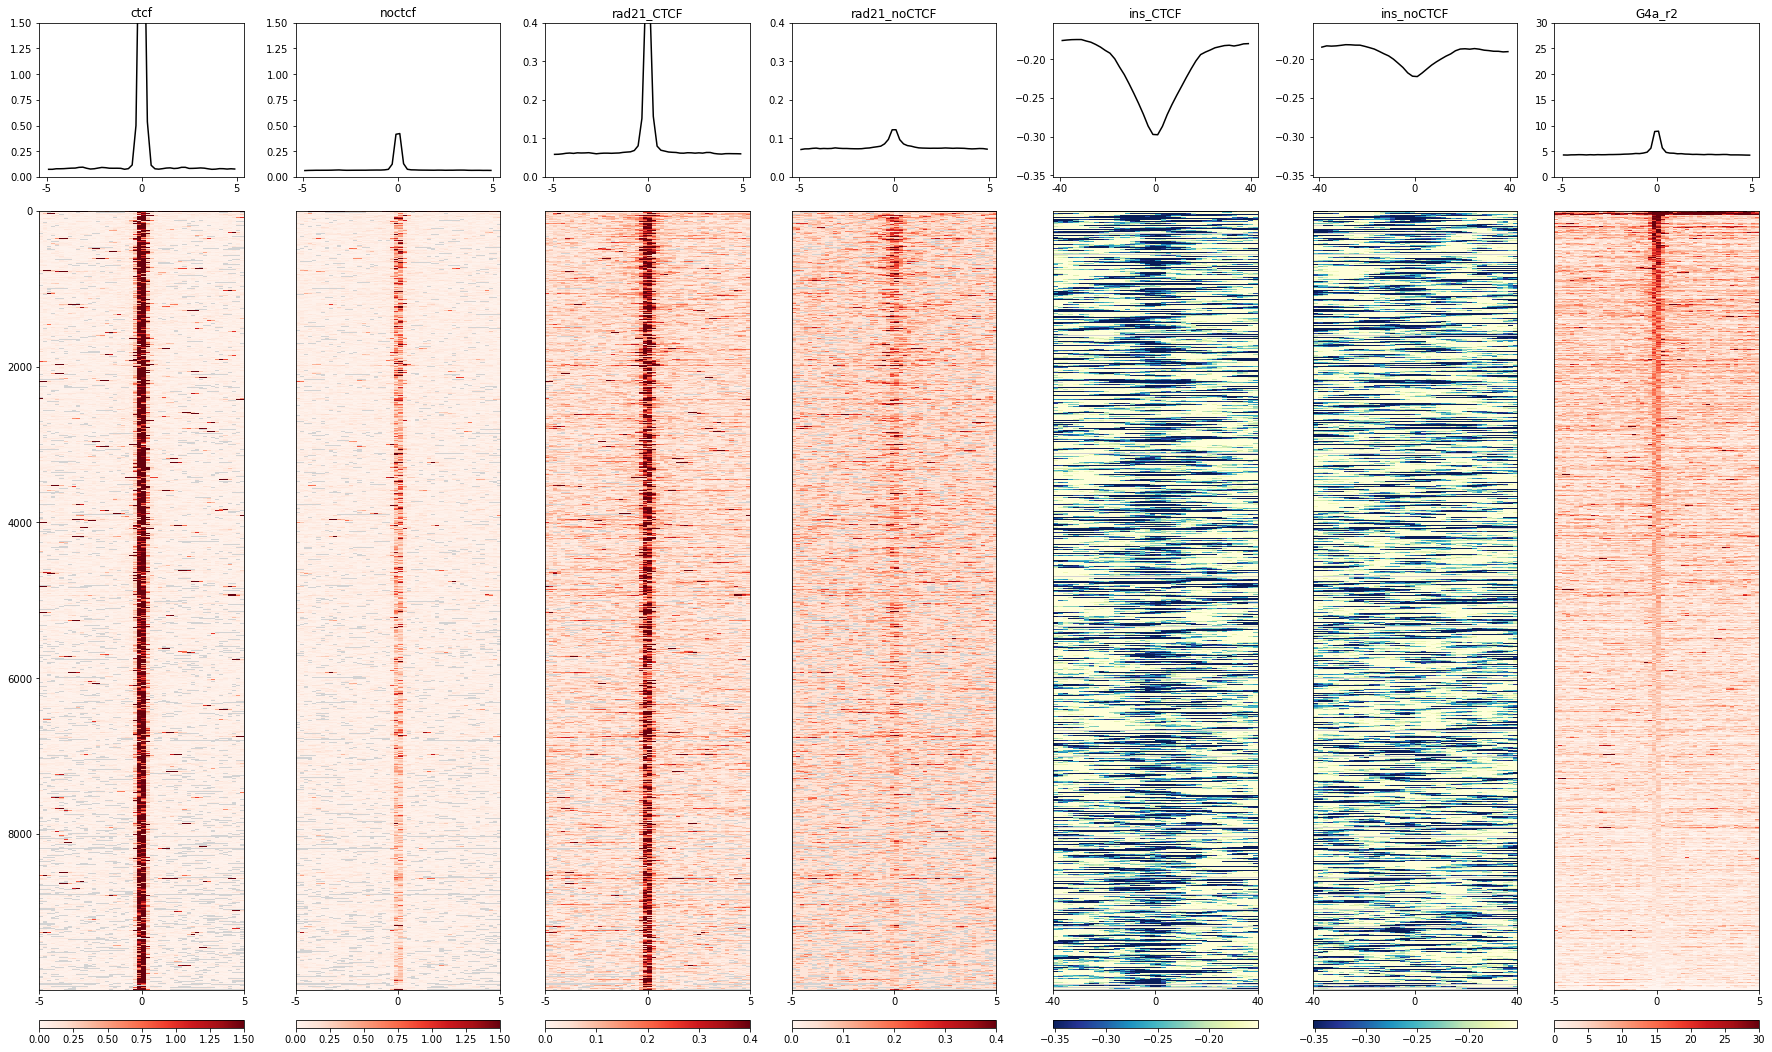

In [46]:
# let's take ~10'000 strongest CTCF harboring RAD21 peak
iii = jjj[:10_000]
_l, _w = stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

# _l, _w = stackups['ins_CTCF'].shape
# _cent = int(_w/2)
# tmp_dict = {}
# tmp_dict["ins"] = np.nanmean(stackups['ins_CTCF'][iii,_cent-2:_cent+2],axis=1)

ks = [('G4_mean', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ stackups[_k][iii[iii_reord]] for _k in fig1_samples ]
_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

plot_stackups(None, hmss,titles,_limss,_cmps,_norms,_binsizes,fname="Fig1_masterlist_CTCFdep.pdf",fillmissing=False,interpolation="nearest")
# plot_stackups(None, hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
df_merged.loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFdependent.bed",sep="\t",index=False,header=False)


sorting 10000 elements of G4_mean into 1 groups ...


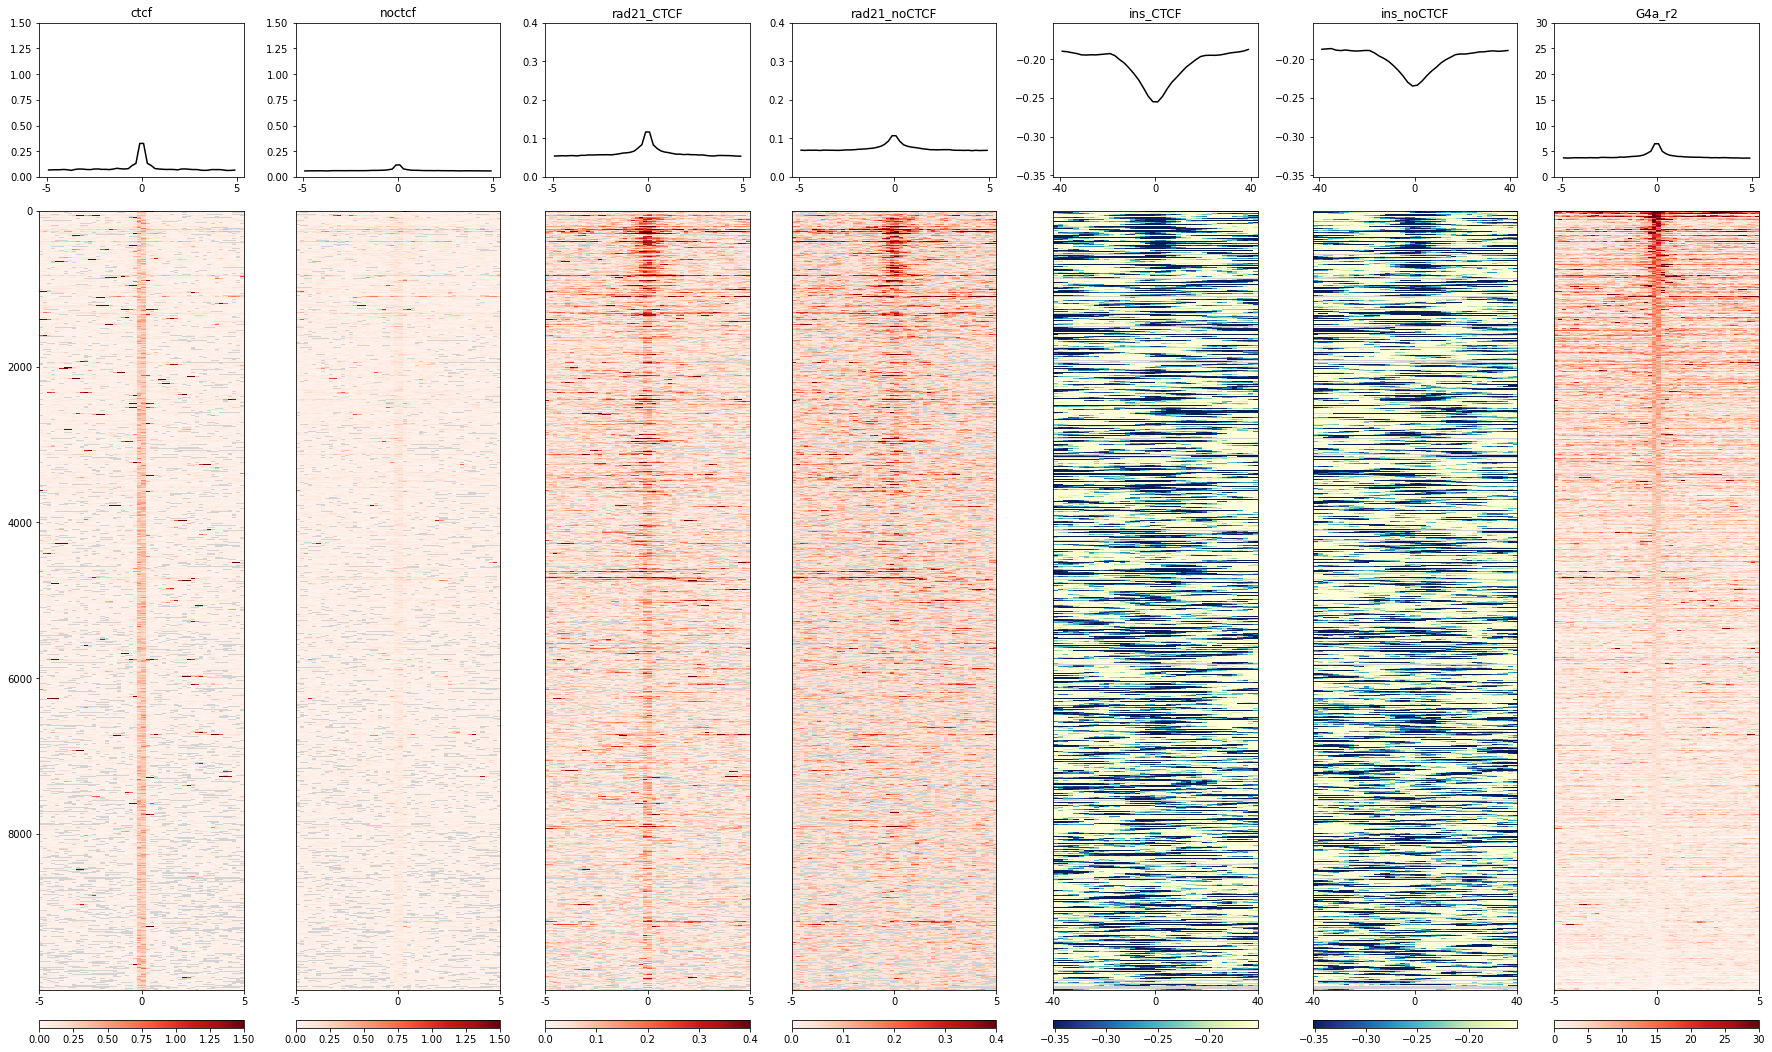

In [48]:
# let's take ~10'000 weakest CTCF harboring RAD21 peak
iii = jjj[15_000:25_000]


_l, _w = stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

# _l, _w = stackups['ins_CTCF'].shape
# _cent = int(_w/2)
# tmp_dict = {}
# tmp_dict["ins"] = np.nanmean(stackups['ins_CTCF'][iii,_cent-2:_cent+2],axis=1)

ks = [('G4_mean', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ stackups[_k][iii[iii_reord]] for _k in fig1_samples ]
_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="Fig1_masterlist_CTCFmiddle.pdf",fillmissing=False,interpolation="nearest")
df_merged.loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFmiddle.bed",sep="\t",index=False,header=False)
# masterlist_CTCFmiddle.bed

sorting 10000 elements of G4_mean into 1 groups ...


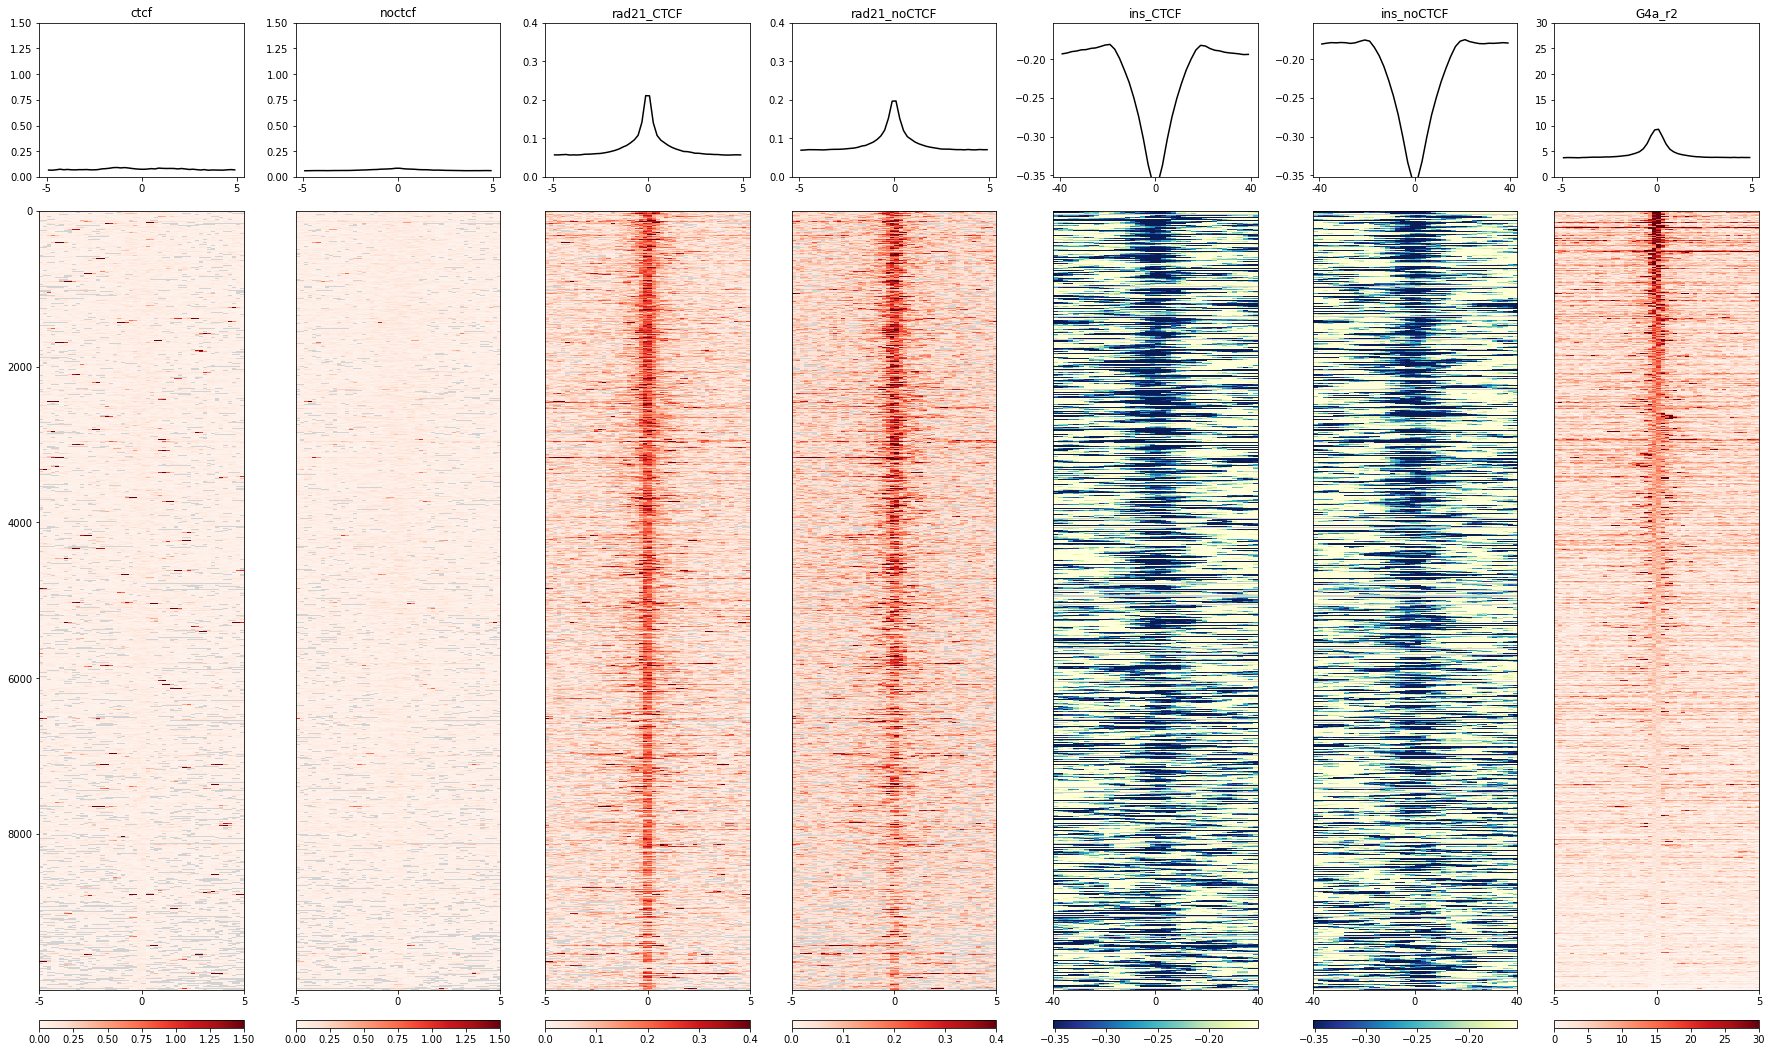

In [49]:
# let's take ~10'000 weakest CTCF harboring RAD21 peak
iii = jjj[-10_000:]


_l, _w = stackups['G4a_r2'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict['G4_mean'] = np.nanmean(stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

# _l, _w = stackups['ins_CTCF'].shape
# _cent = int(_w/2)
# tmp_dict = {}
# tmp_dict["ins"] = np.nanmean(stackups['ins_CTCF'][iii,_cent-2:_cent+2],axis=1)

ks = [('G4_mean', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)

hmss = [ stackups[_k][iii[iii_reord]] for _k in fig1_samples ]
_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="Fig1_masterlist_CTCFindep.pdf",fillmissing=False,interpolation="nearest")
# plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.pdf",fillmissing=False,interpolation="nearest")
df_merged.loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFindependent.bed",sep="\t",index=False,header=False)


In [58]:
# # check what we have here locally ...
# ! ls Fig1*pdf
# ! ls master*bed
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021

In [66]:
# !scp Fig1_masterlist* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### not really needed for Fig1 - just some different examples of sorting the zoom-ins ...

In [ ]:
# let's take remaining RAD21 peaks without CTCF (weak CTCF signal)
iii = jjj[-10_000:]

# _l, _w = stackups['G4a_r2'].shape
# _cent = int(_w/2)
# tmp_dict = {}
# tmp_dict['G4_mean'] = np.nanmean(stackups['G4a_r2'][iii,_cent-5:_cent+5],axis=1)

_l, _w = stackups['ins_CTCF'].shape
_cent = int(_w/2)
tmp_dict = {}
tmp_dict["ins"] = np.nanmean(stackups['ins_CTCF'][iii,_cent-2:_cent+2],axis=1)

ks = [('ins', "sort", 1, False)]
_, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)


hmss = [ stackups[_k][iii[iii_reord]] for _k in fig1_samples ]
_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="x3.pdf",fillmissing=False,interpolation="nearest")

In [ ]:
# df_merged.loc[iii[iii_reord][:2000]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_noINS.bed",sep="\t",index=False,header=False)
# df_merged.loc[iii[iii_reord][3000:5000]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_weakINS.bed",sep="\t",index=False,header=False)
# df_merged.loc[iii[iii_reord][5000:7900]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_mediumINS.bed",sep="\t",index=False,header=False)
# df_merged.loc[iii[iii_reord][9500:]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_strongINS.bed",sep="\t",index=False,header=False)
# # # df_merged.loc[iii[iii_reord][:4000]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_strongG4.bed",sep="\t",index=False,header=False)


In [ ]:
# !scp RAD21peaks_noCTCF*INS.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [ ]:
# df_merged.loc[iii[iii_reord][-2000:]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_noG4.bed",sep="\t",index=False,header=False)
# df_merged.loc[iii[iii_reord][:4000]][["chrom","start","end"]].to_csv("RAD21peaks_noCTCF_strongG4.bed",sep="\t",index=False,header=False)
# !wc -l RAD21peaks_noCTCF_strongG4.bed